In [1]:
import numpy as np
import pandas as pd

# P1 Carga y Limpieza de datos

### 1- . Carga

In [2]:
def obtener_semana(week):
    week = str(week)
    # Traemos los dataframe
    all_info = pd.read_csv('./data/raw/w'+week +
                           '/metrocuadrado_all_w'+week+'.csv')
    all_info.drop_duplicates(inplace=True)
    furnished = pd.read_csv('./data/raw/w'+week +
                            '/metrocuadrado_furnished_w'+week+'.csv')
    furnished.drop_duplicates(inplace=True)

    # Merge que identifica furnished dentro de all_info
    df = pd.merge(all_info, furnished, on=['property_type|rent_type|location', 'details', 'url', 'surface', 'price'],
                  how='outer', indicator=True)
    df.rename(columns={'n_rooms_x': 'n_rooms', 'n_bath_x': 'n_bath',
                       'metrocuadrado_index_x': 'metro_cuadrado'}, inplace=True)

    # Indices que solo hay en furnished
    indices = df[df._merge == 'right_only'].index
    for i in indices:
        df.loc[i, 'n_rooms'] = df.loc[i, 'n_rooms_y']
        df.loc[i, 'n_bath'] = df.loc[i, 'n_bath_y']
        df.loc[i, 'metro_cuadrado'] = df.loc[i, 'metrocuadrado_index_y']

    # Dropeamos los _y
    df.drop(['n_rooms_y', 'n_bath_y', 'metrocuadrado_index_y'],
            axis=1, inplace=True)

    # Dropeamos los duplicados y reseatmos indice
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [3]:
def append_dataframes():
    week_list = range(13, 18)
    df = pd.DataFrame()

    for week in week_list:
        df = df.append(obtener_semana(week))

    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [4]:
# Iniciar Data frame
df = append_dataframes()

Si hay furnished que no hay en all, identificados como 'right_only' de la columna _merge

### 2- . Limpieza

##### a)

In [5]:
# Limpiamos la columna price
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace('.', '')
df['price'] = df['price'].apply(float)

In [6]:
# Limpiamos la columna surface
df['surface'] = df['surface'].str.replace('m2', '')
df['surface'] = df['surface'].apply(float)

Vemos los Dtype

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16379 entries, 0 to 16378
Data columns (total 9 columns):
property_type|rent_type|location    16379 non-null object
price                               16379 non-null float64
n_rooms                             16345 non-null object
n_bath                              16150 non-null object
surface                             16379 non-null float64
details                             16269 non-null object
url                                 16379 non-null object
metro_cuadrado                      16379 non-null float64
_merge                              16379 non-null category
dtypes: category(1), float64(3), object(5)
memory usage: 1.0+ MB


##### b)

In [8]:
# Split de la comuna
s = pd.Series(df.keys())
split = s.str.split('|', expand=True)

# Columnas de transicion
df[['property_type+rent_type', 'location']] = df['property_type|rent_type|location'].str.split(',', expand=True)
df[['property_type','rent_type']] = df['property_type+rent_type'].str.split(' en ', expand=True)

# Dropeamos las extra
df = df.drop(['property_type|rent_type|location', 'property_type+rent_type'], axis=1)

### 3- . Creación de columnas indicadoras

#### a)

In [9]:
# Creamos columna precio m2
df['precio_m2'] = df['price']/df['surface']

#### b)

In [10]:
def num_garajes(url):
    url_splitted = url.split('-garajes')
    # Si no hacemos split
    if len(url_splitted) == 1:
        return 0
    else:
        # Agarramos las ultimos dos caracteres XX-garajes
        n = url_splitted[0][-2:]
        # Si es del tipo -1-garajes, devolvemos 1
        if n[0] == '-':
            return n[1]
        return n


# Creamos la columna n_garajes
df['n_garajes'] = df['url'].apply(num_garajes)

In [11]:
# Limpiamos n_garajes, sujeto a cambios
df['n_garajes'] = df['n_garajes'].replace('4+',5)
df['n_garajes'] = df['n_garajes'].apply(float)

### 4- . Clasificación por tipo de producto

In [12]:
# Inicializamos la columna tipo
df['tipo'] = -1


def clasifica_producto(df):
    # Areas
    area_min = [80, 120, 180, 240, 360, 40, 60, 80]
    area_max = [120, 180, 240, 360, 460, 60, 80, 120]

    # Query
    for tipo_prod in range(1, 9):
        minimo = area_min[tipo_prod-1]
        maximo = area_max[tipo_prod-1]
        # Query para tipos 1-5
        if tipo_prod < 6:
            query = 'property_type == "Casa" and {} < surface < {}'.format(minimo, maximo)
            indices = df.query(query).index
            for i in indices:
                df.loc[i, 'tipo'] = tipo_prod
        else:
            query = 'property_type == "Apartamento" and {} < surface < {}'.format(minimo, maximo)
            indices = df.query(query).index
            for i in indices:
                df.loc[i, 'tipo'] = tipo_prod

    return df


# Actualizamos el dataframe
df = clasifica_producto(df)

In [13]:
df

,price,n_rooms,n_bath,surface,details,url,metro_cuadrado,_merge,location,property_type,rent_type,precio_m2,n_garajes,tipo
0,1050000.0,3,2,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only,LA SOLEDAD NORTE Bogotá D.C..,Casa,Arriendo,1.666667e+04,1.0,-1
1,3930000.0,3,2,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,Casa,Arriendo,3.930000e+04,1.0,1
2,750000.0,3,1,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only,VILLA DE LOS ALPES II SECTOR Bogotá D.C..,Casa,Arriendo,8.333333e+03,0.0,1
3,3400000.0,5,4,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,left_only,PARIS GAITAN Bogotá D.C..,Casa,Arriendo,4.788732e+04,0.0,-1
4,1560000.0,4,3,96.0,"Excelente casa de tres niveles, buena ubicació...",https://www.metrocuadrado.com/inmueble/arriend...,47.1,left_only,BALCONES DE ORIENTE Bogotá D.C..,Casa,Arriendo,1.625000e+04,1.0,1
5,1100000.0,3,2,69.0,"Casa en conjunto cerrado, recién remodelada, c...",https://www.metrocuadrado.com/inmueble/arriend...,32.4,left_only,TIBABUYES Bogotá D.C..,Casa,Arriendo,1.594203e+04,0.0,-1
6,3400000.0,4,4,71.0,casa ezquinera tres niveles excelente ubicacio...,https://www.metrocuadrado.com/inmueble/arriend...,60.9,left_only,PARIS GAITAN Bogotá D.C..,Casa,Arriendo,4.788732e+04,1.0,-1
7,1400000.0,4,2,82.0,casa en conjunto cerrado consta de tres pisos ...,https://www.metrocuadrado.com/inmueble/arriend...,52.9,left_only,PORTALES DEL NORTE Bogotá D.C..,Casa,Arriendo,1.707317e+04,1.0,1
8,1200000.0,3,2,72.0,Cómoda casa en sector residencial de Ciudadela...,https://www.metrocuadrado.com/inmueble/arriend...,40.9,left_only,URBANIZACION BOLIVIA ORIENTAL Bogotá D.C..,Casa,Arriendo,1.666667e+04,1.0,-1
9,1400000.0,4,2,100.0,Casa en arriendo de 2 niveles en La Isabela 2 ...,https://www.metrocuadrado.com/inmueble/arriend...,33.3,left_only,URBANIZACION AZAFRANES Bogotá D.C..,Casa,Arriendo,1.400000e+04,1.0,1


Hay que arreglar, hay casas con menos de 80 de surface

### 5- .

In [14]:
upz = pd.read_csv('./data/asignacion_upz/barrio-upz.csv')

In [15]:
def transforma_str(elemento):
    if type(elemento) == str:
        espaciado = elemento.strip()
        if len(espaciado) != 0:
            return elemento
    else:
        return '-nulo-'


upz['pro_location'] = upz['pro_location'].apply(transforma_str)
upz['pro_location'] = upz['pro_location'].apply(str.upper)
upz

,UPlCodigo,UPlTipo,UPlNombre,UPlArea,pro_location
0,UPZ100,1,GALERIAS,2.375681e+06,PALERMO
1,UPZ100,1,GALERIAS,2.375681e+06,BELALCAZAR
2,UPZ100,1,GALERIAS,2.375681e+06,SEARS
3,UPZ100,1,GALERIAS,2.375681e+06,GALERIAS
4,UPZ100,1,GALERIAS,2.375681e+06,BANCO CENTRAL
5,UPZ100,1,GALERIAS,2.375681e+06,EL CAMPIN
6,UPZ83,1,LAS MARGARITAS,1.472415e+06,SAN JOSE
7,UPZ83,1,LAS MARGARITAS,1.472415e+06,LAS MARGARITAS
8,UPZ107,1,QUINTA PAREDES,1.739560e+06,CENTRO NARIÑO
9,UPZ107,1,QUINTA PAREDES,1.739560e+06,GRAN AMERICA


In [16]:
# Inicializamos la columna
df['upz'] = -1

def clasifica_upz(df):
    locaciones = list(upz['pro_location'])
    codigos_upl = list(upz['UPlCodigo'])
    
    for codigo, locacion in zip(codigos_upl, locaciones):
        indice = df[df['location'].str.contains(locacion)].index
        
        for i in indice:
            df.loc[i,'upz'] = codigo
    
    return df


df = clasifica_upz(df)
print('Porcentaje de objetos con código UPZ')
len(df[df['upz'] != -1])/len(df) * 100

Porcentaje de objetos con código UPZ


91.88595152329202

### 6- .

In [17]:
est_poblacion = pd.read_csv('./data/estadisticas_upz/estadisticas_poblacion.csv')
est_poblacion.drop(columns = ['Unnamed: 0', 'nomupz'], inplace = True)
est_poblacion.head()

,upz,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc
0,UPZ11,68430,0.6,3.9,20.7,35.2,44.579934,17.931973
1,UPZ12,50037,1.8,16.7,9.1,54.7,36.279630,5.420442
2,UPZ13,102981,0.0,3.5,5.5,118.4,33.286852,3.250000
3,UPZ18,69961,0.4,7.2,9.4,42.7,36.465059,9.439051
4,UPZ19,121158,0.3,8.0,8.2,59.1,32.887202,5.406574


In [18]:
# Enriquecemos df con los datos de est_poblacion
df = df.merge(est_poblacion, on = 'upz',how = 'left')

In [19]:
ind_inseg = pd.read_csv('./data/estadisticas_upz/indice_inseguridad.csv')
ind_inseg = ind_inseg.rename(columns = {'UPlCodigo' : 'upz'})
ind_inseg.drop(columns=['UPlNombre2','Unnamed: 0'], inplace=True)
ind_inseg.head()

,upz,indice_inseguridad
0,UPZ100,0.671141
1,UPZ83,0.000000
2,UPZ107,2.318841
3,UPZ101,3.629032
4,UPZ91,13.537118


In [20]:
# Enriquecemos df con el indice de inseguridad
df = df.merge(ind_inseg, on = 'upz',how = 'left')

In [21]:
per_areas_verdes = pd.read_csv('./data/estadisticas_upz/porcentaje_areas_verdes.csv')
per_areas_verdes.head()

,Unnamed: 0,cod_upz,upz,areas_verdes_perc
0,0,51.0,Los Libertadores,58.196667
1,1,87.0,Tintal Sur,85.924848
2,2,1.0,Paseo de los Libertadores,83.966495
3,3,64.0,Monte Blanco,85.778144
4,4,29.0,Minuto de Dios,37.852289


In [22]:
per_areas_verdes.rename(columns={'upz': 'zona','cod_upz': 'upz'},inplace=True)
per_areas_verdes['upz'] = per_areas_verdes['upz'].astype(int)
per_areas_verdes['upz'] = per_areas_verdes['upz'].astype(str)
per_areas_verdes['upz'] = per_areas_verdes['upz'].apply(lambda num: 'UPZ'+num)
per_areas_verdes['upz'] = per_areas_verdes['upz'].apply(str.upper)
per_areas_verdes.drop(columns=['Unnamed: 0'],inplace=True)
per_areas_verdes.head()

,upz,zona,areas_verdes_perc
0,UPZ51,Los Libertadores,58.196667
1,UPZ87,Tintal Sur,85.924848
2,UPZ1,Paseo de los Libertadores,83.966495
3,UPZ64,Monte Blanco,85.778144
4,UPZ29,Minuto de Dios,37.852289


In [23]:
# Enriquecemos df con el porcentaje de areas verdes
df = df.merge(per_areas_verdes, on = 'upz',how = 'left')
df.head(3)

,price,n_rooms,n_bath,surface,details,url,metro_cuadrado,_merge,location,property_type,...,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc,indice_inseguridad,zona,areas_verdes_perc
0,1050000.0,3,2,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,left_only,LA SOLEDAD NORTE Bogotá D.C..,Casa,...,19451.0,0.6,18.4,7.2,145.7,44.896230,5.281135,3.629032,Teusaquillo,6.563105
1,3930000.0,3,2,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,both,CIUDAD SALITRE SUR-ORIENTAL Bogotá D.C..,Casa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,750000.0,3,1,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,left_only,VILLA DE LOS ALPES II SECTOR Bogotá D.C..,Casa,...,179732.0,0.4,1.2,14.5,45.4,31.113458,14.928786,0.310559,Fontibón,21.756250


In [24]:
df.replace(np.inf, np.nan,inplace=True)
df.replace(-np.inf, np.nan,inplace=True)
#df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16381 entries, 0 to 16380
Data columns (total 25 columns):
price                                      16381 non-null float64
n_rooms                                    16347 non-null object
n_bath                                     16152 non-null object
surface                                    16381 non-null float64
details                                    16271 non-null object
url                                        16381 non-null object
metro_cuadrado                             16381 non-null float64
_merge                                     16381 non-null category
location                                   16381 non-null object
property_type                              16381 non-null object
rent_type                                  16381 non-null object
precio_m2                                  16365 non-null float64
n_garajes                                  16381 non-null float64
tipo                                   

# P2

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats

def estilo():
    sns.set_style('dark')
    sns.despine()

In [26]:
names = ['numeric', 'categorical']
# Se crea una lista con las columnas numericas
numeric = ['price', 'surface', 'metro_cuadrado', 'precio_m2', 
           'personas', 'trabajoinf_ninos_5_17_anos_perc',
       'trabajoinfampliado_ninos_5_17_anos_perc',
       'jovenes_14_24_anos_nini_perc', 'indice_envegecimiento',
       'jefe_mujer_perc', 'adultos_mayores_pobres_perc', 'indice_inseguridad',
       'areas_verdes_perc'
]

# Se crea una lista con las columnas categoricas
categorical = list(set(df.columns) - set(numeric))


mapping = [('numeric', col) for col in numeric]
mapping.extend([('categorical', col) for col in categorical])
'''
Se reordenan las columnas del dataframe para que coincidan con el esquema 
del multi indice
'''

df = df.reindex(columns=numeric + categorical)

In [27]:
# Se reasignan las columnas
df.columns = pd.MultiIndex.from_tuples(mapping)

price
surface
metro_cuadrado
precio_m2
personas
trabajoinf_ninos_5_17_anos_perc
trabajoinfampliado_ninos_5_17_anos_perc
jovenes_14_24_anos_nini_perc
indice_envegecimiento
jefe_mujer_perc
adultos_mayores_pobres_perc
indice_inseguridad
areas_verdes_perc


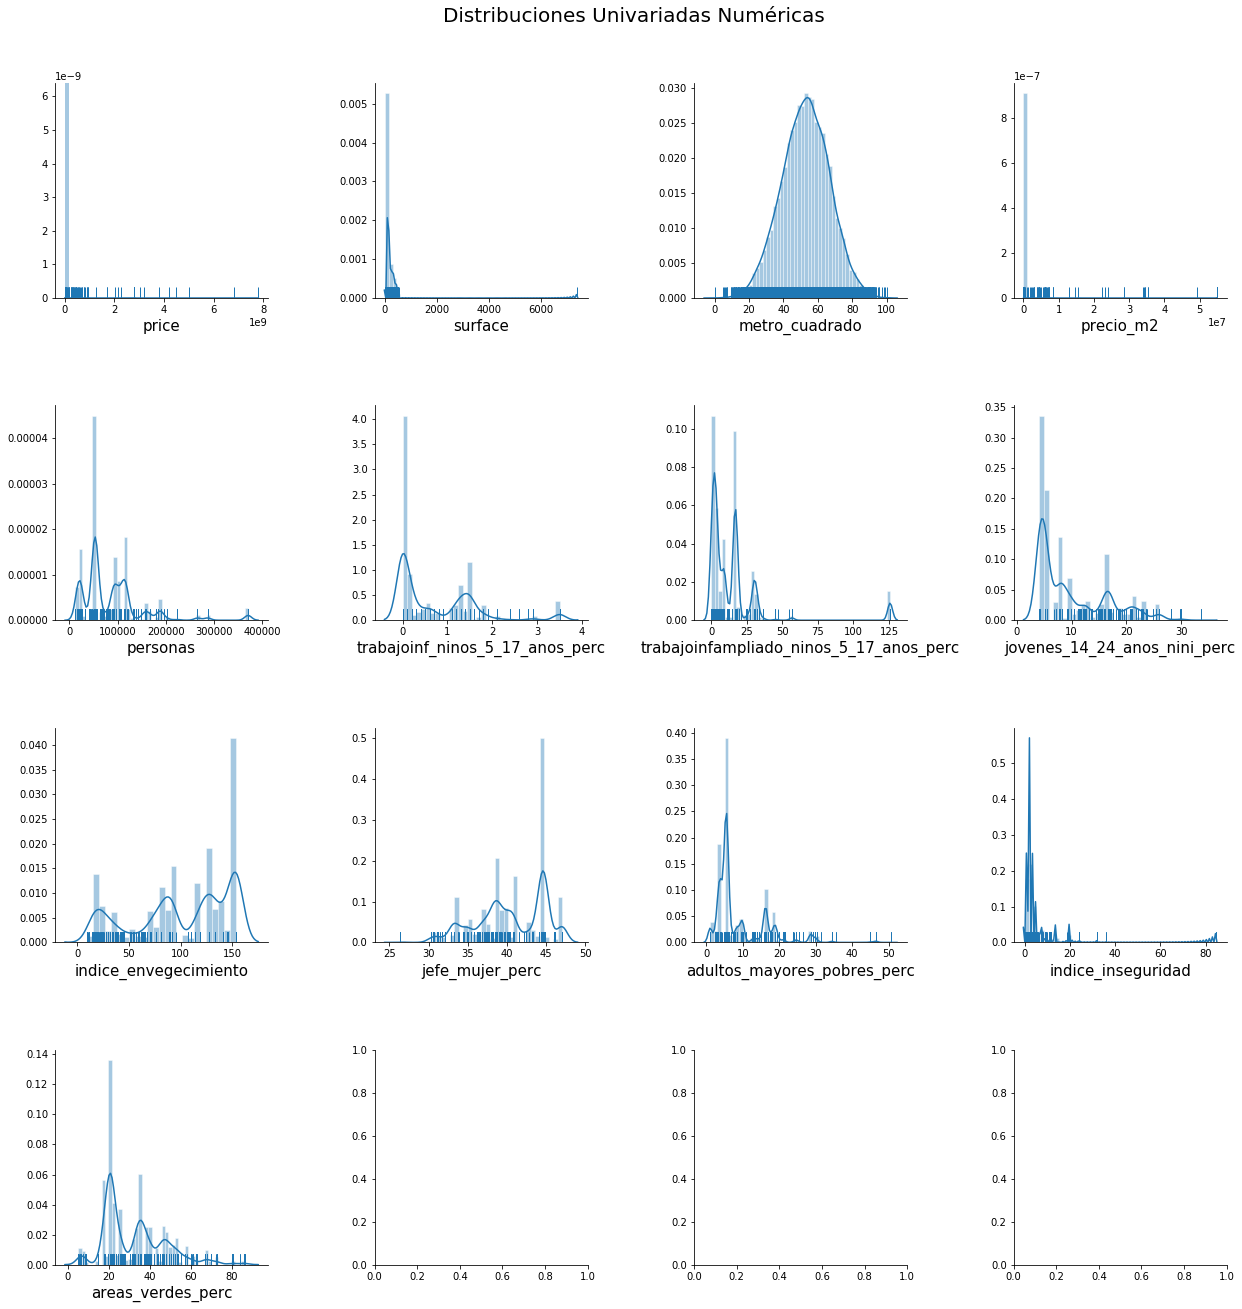

In [28]:
# Grilla de subplots
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=[17, 17])



# Se ajusta el espaciado exterior de la figura
fig.tight_layout()

# Se define un titulo y su ubicacion
fig.suptitle('Distribuciones Univariadas Numéricas',
             fontsize=20,
             x=0.5,
             y=1.05)
for axis, col in zip(ax.flatten(), numeric):
    print(col)
    try :
        # Graficos para datos numericos
        sns.distplot(df[('numeric', col)].dropna(), ax=axis, rug=True)
        estilo()       
    except RuntimeError:
        sns.distplot(df[('numeric', col)].dropna(), ax=axis, rug=True, kde=False)
        estilo()
    axis.set_xlabel(col, fontsize=15)

# Se ajusta el espaciado interno entre subplots
w, h = (.5, 0.5)
plt.subplots_adjust(wspace=w, hspace=h)
estilo()
plt.savefig('distribuciones_univariadas.png')
plt.show()

In [ ]:
# Grilla de subplots
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[17, 17])


# Se ajusta el espaciado exterior de la figura
fig.tight_layout()

# Se define un titulo y su ubicacion
fig.suptitle('Distribuciones Univariadas Categóricas',
             fontsize=20,
             x=0.5,
             y=1.05)
cat_not_url=[cat for cat in categorical if ((cat!='url') & (cat!='upz') )]

for axis, col in zip(ax.flatten(), cat_not_url):

    # Graficos para datos tipos str
    sns.countplot(df[('categorical',col)], ax=axis)
    axis.set_axis_off()
    axis.set_title(col, fontsize=15)
    estilo()
  
    
# Se ajusta el espaciado interno entre subplots
h, w = (.4, .1)
plt.subplots_adjust(wspace=w, hspace=h)



/home/jipi/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/jipi/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 11 missing from current font.
  font.set_text(s, 0.0, flags=flags)


In [ ]:
# Datos faltantes
import missingno as msno
df.replace('nan',np.nan,inplace=True)
print('Valores nan')
print(df.isnull().sum())
print('Mayor info perdida')
print(df.isnull().sum().nlargest(10))

In [ ]:
fig, ax = plt.subplots(figsize = [15, 10])
msno.matrix(df,ax = ax, sparkline=False)

In [ ]:
# Correlaciones de nulidad entre pares de variables
fig, ax = plt.subplots(figsize = [15, 10])
msno.heatmap(df, ax = ax)

In [ ]:
largest_nulls = df.isnull().sum().nlargest(10)

In [ ]:
nulls = df[largest_nulls.index]

In [ ]:
nulls

In [ ]:
msno.dendrogram(nulls)

In [ ]:
# dropear no mas
df1=df.copy()
df1.dropna(inplace=True)
fig, ax = plt.subplots(figsize = [15, 10])
# dropear precio cero
df1.drop(df1.loc[df1.numeric.precio_m2==0].index)
# Eliminar filas con datos faltantes
df1=df.copy()
df1.dropna(inplace=True)

In [ ]:
est_poblacion

In [ ]:
from sklearn.cluster import KMeans

X1=est_poblacion.drop(columns=['upz'])
X1.index=est_poblacion.upz
n_clu=4
kmeans=KMeans(n_clusters=n_clu).fit_predict(X1)
X1['clusters_upz']=kmeans

assignator= lambda upz: str(X1.loc[upz]['clusters_upz'])

df1[('categorical','upz_cluster')]=df1.categorical.upz.apply(assignator)

n_com=len(X1.keys())
fig, axes =plt.subplots(n_com,n_com,figsize=(15,15))
fig.suptitle('')
for i in range(n_com):
    for j in range(n_com):
        axes[i,j].scatter(X1[X1.keys()[i]],X1[X1.keys()[j]],c=kmeans)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
        estilo()
plt.show()

In [ ]:
def violin_and_frec_plot(categorical_variable,title1,title2):
    fontdict = {'fontsize':20}
    fig, ax = plt.subplots(2,1,figsize=[12,13])
    sns.violinplot(('categorical', categorical_variable),
                y=('numeric', 'precio_m2'),
                data=df1,
                kind='violin',
                ax=ax[0])
    sns.countplot(df1[('categorical',categorical_variable)], ax=ax[1])
    ax[0].set_xlabel(categorical_variable, fontdict)
    ax[1].set_xlabel(categorical_variable, fontdict)
    #ax[0].set_ylim(0,100000000)
    ax[0].set_ylabel(r'Precio x $m^2$', fontdict)
    ax[0].set_title(title1, fontdict)
    ax[1].set_title(title2, fontdict)
    h, w = (.3, .1)
    plt.subplots_adjust(wspace=w, hspace=h)
    
violin_and_frec_plot('upz_cluster','Violin plot upz en cluster vs Precio x $m^2$','Frecuencias cluster upz')

In [ ]:
violin_and_frec_plot('tipo','tipo','tipo')
violin_and_frec_plot('_merge','merge','merge')
violin_and_frec_plot('property_type','inmueble','inmueble')
violin_and_frec_plot('zona','zona','zona')

In [ ]:
def scatter_dists(col, df=df1, h=.3, w=.1, fontdict={'fontsize': 20}, reg=True):
    ''' Recibe una columna numerica y genera una visualizacion comparativa.
    
    Genera una figura por sobre el dataframe HousePricing (por defecto), recibe 
    parametros extra como el espaciado entre subfigura.
    
    Args:
    ----------
    
    col: String
         El nombre de la columna numerica a visualizar
    
    h,w: float
        Espaciado entre subplot h -> vertical, w -> horizontal
    
    fontdict: dict
             Permite configurar las fuentes de los subplots
    reg: bool
         Permite graficar una regresion lineal sobre los datos (if True)
        
    Returns: None
        Se muestra una figura en pantalla    
    
    '''
    fig, ax = plt.subplots(2, 1, figsize=[12, 13])
    if reg:
        sns.regplot(x=df[('numeric', col)],
                    y=df[('numeric', 'precio_m2')],
                    ax=ax[0])
        ax[0].set_title(r'Regplot plot {} vs Precio por m^2'.format(col), fontdict)
    else:
        sns.scatterplot(('numeric', col),
                        y=('numeric', 'precio_m2'),
                        data=df,
                        ax=ax[0])
        ax[0].set_title(r'Scatter plot {} vs Precio por m^2'.format(col), fontdict)

    
    # Distribucion univariada
    sns.distplot(df[('numeric', col)], ax=ax[1])
    ax[0].set_ylim(0,100000)
    ax[0].set_xlabel(col, fontdict)
    ax[1].set_xlabel(col, fontdict)

    ax[0].set_ylabel('Precio por m^2', fontdict)
    ax[1].set_title('Frecuencias {}'.format(col), fontdict)

    plt.subplots_adjust(wspace=w, hspace=h)


In [ ]:
scatter_dists('n_rooms')
scatter_dists('n_bath')
scatter_dists('surface')
scatter_dists('metro_cuadrado')
scatter_dists('n_garajes')
scatter_dists('personas')
scatter_dists('trabajoinf_ninos_5_17_anos_perc')
scatter_dists('trabajoinfampliado_ninos_5_17_anos_perc')

In [ ]:
# Perfilamiento Bivariado
# Se genera una función auxiliar
def indexer(cols, t_c = df1.columns):
        '''Genera columnas multinivel a partir de nombres de columna planos.'''

        set_to_tuple = set(*[cols])

        tuples = [
            i for i in t_c if set_to_tuple.intersection(set(i))
        ]
        return tuples
def perfil_bivariado(interest):
    # Variables a examinar
    idxs = indexer(interest)
    df1[idxs].head()
    # Pone precio_m2 al final de la lista
    idxs.sort()
    idxs.remove(('numeric', 'precio_m2'))
    idxs.append(('numeric', 'precio_m2'))
    # para que Seaborn entienda
    data = df1.reindex(idxs, axis=1).droplevel(0,axis=1)
    # quitar 100 datos con precio mas grande para poder visualizar mejor
    data.drop(data.precio_m2.nlargest(100).index)

    sns.pairplot(data = data, diag_kind='kde')

In [ ]:
interest1=['precio_m2', 'n_rooms', 'n_bath', 'surface', 'n_garajes','property_type', 'upz_group','tipo','metro_cuadrado']
perfil_bivariado(interest1)
interest2=['precio_m2','jefe_mujer_perc','indice_envegecimiento','adultos_mayores_pobres_perc','tipo']
perfil_bivariado(interest2)

In [ ]:
# matriz de correlaciones
corr_matrix=df1.corr()
col = indexer(['precio_m2'])
print('10 variables más correlacionadas')
print(corr_matrix[col].nlargest(10,col))
print('3 variables menos correlacionadas')
print(corr_matrix[col].nsmallest(3,col))


# Visualizar

'''
Se inserta 'precio_m2' como primera fila x columna de la matriz de correlacion
'''

unsorted = list(corr_matrix.columns)
unsorted.remove(*col)
unsorted.insert(0, *col)

sortd = pd.MultiIndex.from_tuples(unsorted)
corrmat = corr_matrix.reindex(index = sortd, columns = sortd)
'''
Dado lo anterior, se ajusta el anchor de colores con maximo en .9
y -0.5, para tener una perspectiva entorno a los valores maximos 
de correlacion (negativa y positiva)
'''

fig, ax = plt.subplots(figsize=[16, 14])

sns.heatmap(corrmat, vmin=-.5, vmax=.9, linewidths=.01)

In [ ]:
# analisis categórico versus categóricos

data_cat = df1['categorical']
def categorical_compa(cat1,cat2):
    to_compare=[cat1,cat2]
    kwargs = {'index': data_cat[to_compare[0]], 'columns': data_cat[to_compare[1]]}
    tabla = pd.crosstab(**kwargs, margins=True, margins_name='Total')
    return tabla

In [ ]:
categorical_compa('rent_type','property_type')

In [ ]:
categorical_compa('rent_type','tipo')

In [ ]:
categorical_compa('tipo','zona')

In [ ]:
categorical_compa('upz_cluster','tipo')

In [ ]:
# comparar con test xi^2
from scipy.stats import chi2_contingency
def test_xi(cat1,cat2):
    to_compare=[cat1,cat2]
    kwargs = {'index': data_cat[to_compare[0]], 'columns': data_cat[to_compare[1]]}
    tabla = pd.crosstab(**kwargs, margins=False)
    chi2, p, dof, ex =chi2_contingency(tabla)
    expected_freq = pd.DataFrame(ex, index=df1.categorical[cat1].unique())
    expected_freq.index.name = cat1
    expected_freq.columns.name = cat2
    return p,expected_freq

p, table=test_xi('upz_cluster','tipo')
print(p)
table

In [ ]:
p, table=test_xi('rent_type','tipo')
print(p)
table

# P3

### Implementación. 1

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from numpy import matmul
from numpy.linalg import pinv, eig
import sys
import time
import numpy as np

class RegresionBayesianaEmpirica(BaseEstimator, RegressorMixin):
    def __init__(self, alpha_0, beta_0, tol=1e-5, maxiter=200):
        self.maxiter = maxiter
        self.tol = tol
        self.alpha_0 = alpha_0
        self.beta_0 = beta_0
        self.alpha = alpha_0
        self.beta = beta_0
        self.M_n = None
        self.S_n = None
        
    
    def get_posteriori(self, X, y, alpha, beta):

        S_n = alpha + beta*matmul(X.T, X)
        M_n = beta * matmul(matmul(pinv(S_n), X.T), y)
        return M_n, S_n
    
    
    def fit(self, X, y):
        X = np.hstack((np.ones((1,X.shape[0])).T , X))
        N = len(y)
        for i in range(self.maxiter):
            t0 = time.time()
            eigen_values, _ = eig(self.beta * matmul(X.T, X))
            eigen_values = np.real_if_close(eigen_values)
            gamma = (eigen_values/(self.alpha + eigen_values)).sum()
            M_n, S_n = self.get_posteriori(X, y, self.alpha, self.beta)
            new_alpha = gamma/(matmul(M_n.T, M_n))
            new_beta = (N-gamma)/((y - matmul(M_n.T, X.T))**2).sum() #Revisar X.T
            
            alpha_delta = np.abs(self.alpha - new_alpha)
            beta_delta = np.abs(self.beta - new_beta)
            
            sys.stdout.write(
                      '\rIter:{0:03d}'.format(i+1) + ' Alpha :{0:.5f}'.format(new_alpha)
                      + ' Beta :{0:.5f}'.format(new_beta) 
                      + ' Tiempo/iter:{0:.5f}s'.format(time.time()- t0))   
            
            if (alpha_delta > self.tol or beta_delta > self.tol):
                self.alpha = new_alpha
                self.beta = new_beta
            else:
                self.M_n = M_n
                self.S_n = S_n
                break
        self.M_n = M_n
        self.S_n = S_n
                    
    #Predicción utilizando la media posterior predictiva
    def predict(self, X_, return_std = False):
        X_ = np.hstack((np.ones((1,X_.shape[0])).T , X_))
        mu = matmul(self.M_n.T, X_.T)
        if return_std:
            std = np.sqrt(self.beta**-1 + matmul(matmul(X_.T, self.S_n), X_) )
            return mu, std
        else:
            return mu

In [ ]:
numeric = [tupla[1] for tupla in df1.columns 
           if tupla[0] == 'numeric' and 
           tupla[1]!= 'precio_m2']# and 
           #tupla[1]!= 'price' ]
categorical = [tupla[1] for tupla in df1.columns 
               if tupla[0] == 'categorical' 
               and tupla[1]!= '_merge' 
               and tupla[1]!= 'url'
               and tupla[1]!= 'location'
               and tupla[1]!= 'details'
               and tupla[1]!= 'upz_cluster']

In [ ]:
numeric

In [ ]:
categorical

In [ ]:
X = df1.reindex(df1.columns, axis=1).droplevel(0,axis=1)
y = df1['numeric']['precio_m2']

In [ ]:
from sklearn.model_selection import train_test_split
seed = 3891624866
seed = 0

np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X, np.array(y), test_size=0.2)


In [ ]:
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer()),
                                      #('StandarScaler', StandardScaler()),
                                      ('MinMaxScaler', MinMaxScaler()), 
                                      ('PolynomialFeatures', PolynomialFeatures(degree = 3))])


categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='Nan')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore',sparse = False))])

preprocessor = ColumnTransformer(transformers=[ ('num', numeric_transformer, numeric),
                                                ('cat', categorical_transformer, categorical)])



regressor = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RegresionBayesianaEmpirica(
                          alpha_0 = 1e-8, beta_0 = 1e-8, tol = 1e-14, maxiter = 300))])


regressor.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

Y_pred = regressor.predict(X_test)
r2 = r2_score(y_test, Y_pred)
rmse = mean_squared_error(y_test, Y_pred, squared = False)
print('   RMSE: {0:.3f}'.format(rmse))
print('R2Score: {0:.3f}'.format(r2))

Guardamos el modelo

In [ ]:
import pickle
filename = '0445.sav'
#pickle.dump(regressor, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_train, y_train)
print(result)

Bayesian Ridge regression

In [ ]:
from sklearn.linear_model import BayesianRidge
c=1e-08

bayesian_ridge_regressor = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', BayesianRidge(alpha_1=c, 
                                                   alpha_2=c, 
                                                   lambda_1=c,
                                                   lambda_2=c))])
bayesian_ridge_regressor.fit(X_train,y_train)

In [ ]:
Y_pred = bayesian_ridge_regressor.predict(X_test)
r2 = r2_score(y_test, Y_pred)
rmse = mean_squared_error(y_test, Y_pred, squared = True)
print('   RMSE: {0:.3f}'.format(rmse))
print('R2Score: {0:.3f}'.format(r2))
